# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 2:
  - The client wants to have a ML model so that we can use it to test their HIP software.

## Inputs

* inputs/cats_vs_dogs_dataset/train
* inputs/cats_vs_dogs_dataset/validation
* inputs/cats_vs_dogs_dataset/test
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Machine learning model creation and training.
* Learning curve plot for model performance.
* Model evaluation on pickle file.

## Additional Comments

* 


---

# **Preparation setup**

## Import libraries

In [1]:
%pip install -r /workspace/pp5-cats-vs-dogs/requirements.txt 2>/dev/null | grep -v 'Requirement already satisfied'
print('Requirements installed.')

Note: you may need to restart the kernel to use updated packages.
Requirements installed.


In [2]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Set working directory

Set working directory to root project folder

In [3]:
current_dir = os.getcwd()
print('Current folder: ' + current_dir)
os.chdir(os.path.dirname(current_dir))
root_dir = os.getcwd()
print('New folder: ' + root_dir)

Current folder: /workspace/pp5-cats-vs-dogs/jupyter_notebooks
New folder: /workspace/pp5-cats-vs-dogs


## Set input directories

In [4]:
dataset_folder = 'inputs/cats_vs_dogs_dataset'
train_path = dataset_folder + '/train'
validation_path = dataset_folder + '/validation'
test_path = dataset_folder + '/test'
train_path

'inputs/cats_vs_dogs_dataset/train'

## Set output directory

In [5]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(root_dir) and version in os.listdir(root_dir + '/outputs'):
    print(f'Version {version} is already available.')
    pass
else:
    os.makedirs(name=file_path)
    print(f'New directory for version {version} has been created')

Version v1 is already available.


## Set label names

In [6]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['cat', 'dog']


## Set image shape

In [7]:
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(360, 404, 3)

## Number of images in dataset

* train - cat: 8750 images
* train - dog: 8750 images
* validation - cat: 1250 images
* validation - dog: 1250 images
* test - cat: 2500 images
* test - dog: 2500 images




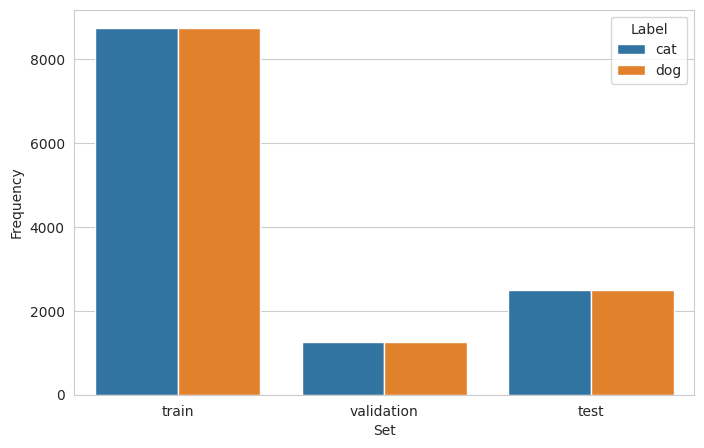

In [8]:
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        new_row = pd.DataFrame({
            'Set': [folder],
            'Label': [label],
            'Frequency': [len(os.listdir(dataset_folder + '/' + folder + '/' + label))]
        })
        df_freq = pd.concat([df_freq, new_row], ignore_index=True)

        print(
            f"* {folder} - {label}: {len(os.listdir(dataset_folder +'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image data generator

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 20

train_set = ImageDataGenerator(rescale=1./255).flow_from_directory(train_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

print(train_set.class_indices)

validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

print(validation_set.class_indices)

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

print(test_set.class_indices)

Found 17500 images belonging to 2 classes.
{'cat': 0, 'dog': 1}
Found 2500 images belonging to 2 classes.
{'cat': 0, 'dog': 1}
Found 5000 images belonging to 2 classes.
{'cat': 0, 'dog': 1}


---

# **Model creation**

## ML model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

### Summary

In [29]:
create_tf_model().summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 358, 402, 16)      448       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 179, 201, 16)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 177, 199, 32)      4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 88, 99, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 86, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 43, 48, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 66048)            

### Early stopping

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit model for training

In [25]:
model = create_tf_model()
model.fit(train_set,
          epochs=10,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
  5/875 [..............................] - ETA: 26:08 - loss: 10.7023 - accuracy: 0.5700

KeyboardInterrupt: 